In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def obj_func(m):
    u, s, vh = np.linalg.svd(m)

    return np.sum(s[1:])

def comp_grad(m, boolMask, obj_func, n, epsilon):
    """ Computes gradient that maximizes the objective function """

    # Yes, grad is a vector now
    grad = []

    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                grad.append((obj_func(m + diff) - obj_func(m - diff))/(2*epsilon))

    return grad

def comp_hessian(m, boolMask, of, n, epsilon):
    """ Computes hessian (only diagonal) """
    vector = []

    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                vector.append(m[i,j])

    q = len(vector)
    hessian = np.zeros([q, q])

    # fill in the diagonal first
    count = 0
    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:

                diff = np.zeros([n,n])
                diff[i,j] = epsilon
                hessian[count,count] = (of(m + diff) + of(m - diff) - 2*of(m))/epsilon**2

                count = count + 1
                
    # now fill in off-diagonals
    count1 = 0
    for i1 in range(n):
        for j1 in range(n):
            if boolMask[i1,j1]: # found one
                diff1 = np.zeros([n,n])
                diff1[i1,j1] = epsilon

                count2 = 0
                for i2 in range(n):
                    for j2 in range(n):
                        if boolMask[i2,j2]: # found another one
                            diff2 = np.zeros([n,n])
                            diff2[i2,j2] = epsilon

                            if count1 != count2: # doing only off-diagonal ones
                                hessian[count1,count2] = (of(m + diff1 + diff2) + of(m - diff1 - diff2)
                                                         - of(m + diff1 - diff2) - of(m - diff1 + diff2))/(2*epsilon)**2

                            count2 = count2 + 1

                count1 = count1 + 1

    return hessian

In [6]:
n = 10
p = 0.5
rank = 1

U = np.random.randn(n, rank)
V = np.random.randn(n, rank)
original = np.dot(U, V.T)
mask = np.random.choice([0, 1], size=(n,n), p=[1-p, p])

boolMask = np.ma.make_mask(np.where(np.array(mask) < 0.5, 1, 0))

In [10]:
current_point = np.copy(original)

zeros = np.zeros([n,n])
current_point[boolMask] = zeros[boolMask]

print("step, nuc norm, frob distance, hessian cond")#, grad mean, grad std, grad min, grad max")
nuc_norms = []
frob_norms = []
conds = []

for step in range(10000):

    best_epsilon = 10
    best_hessian = comp_hessian(current_point, boolMask, obj_func, n, best_epsilon)
    best_cond = np.linalg.cond(best_hessian)
    for p in range(9):
        epsilon = p#10**(-p)
        hessian = comp_hessian(current_point, boolMask, obj_func, n, epsilon)
        cond = np.linalg.cond(hessian)
        if cond < best_cond:
            best_epsilon = epsilon
            best_hessian = hessian
            best_cond = cond
    
    hessian = best_hessian
    grad = comp_grad(current_point, boolMask, obj_func, n, best_epsilon)

    descent = -np.dot(np.linalg.inv(hessian), grad)
    #descent = -np.array(grad)
    
    descent_matrix = np.zeros([n,n])
    count = 0
    for i in range(n):
        for j in range(n):
            if boolMask[i,j]:
                descent_matrix[i,j] = descent[count]
                count = count + 1
    
    current_point = current_point + 0.1*descent_matrix
    
    nuc_norms.append(np.linalg.norm(current_point,'nuc'))
    frob_norms.append(np.linalg.norm(current_point-original,'fro'))
    conds.append(np.linalg.cond(hessian))
    
    #if step % 20 == 0:
    print(step, np.linalg.norm(current_point,'nuc'), np.linalg.norm(current_point-original,'fro'),
              best_cond, best_epsilon)#, np.mean(np.abs(grad)),
             # np.std(np.abs(grad)), np.min(np.abs(grad)), np.max(np.abs(grad)))
    

step, nuc norm, frob distance, hessian cond


/home/dplatonov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/home/dplatonov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


0 13.739552705183227 5.920798650552207 4.608210547302094 10
1 13.410205761228479 5.613458274214489 4.235971869340462 10
2 13.09617108685143 5.309383543608359 3.9253153446880242 10
3 12.79808803132038 5.008499847699801 3.66354576045605 10
4 12.51642692585097 4.710570034650747 3.4411968137540976 10
5 12.251756074515786 4.415437150573404 3.2507684100073275 10
6 12.005664868419053 4.123292253148603 3.086343424104514 10
7 11.782686251522966 3.834775152565889 2.943278292652943 10
8 11.60344039265771 3.5509924761247165 2.818151223913629 10
9 11.480306808152818 3.272830122313718 2.7055096456044643 10
10 11.402494765920798 3.0025101881255156 2.607766774864319 10
11 11.365054024014016 2.7431327826230287 2.5243483502140185 10
12 11.366482650604205 2.4977663019124114 2.4515125570261445 10
13 11.412981645635572 2.2697029758571876 2.385123584866491 10
14 11.529108708558002 2.0619566234924065 2.323677826027051 10
15 11.509073419361794 1.9913321627911695 2.293564220810683 4
16 11.493370394226407 1.922

KeyboardInterrupt: 

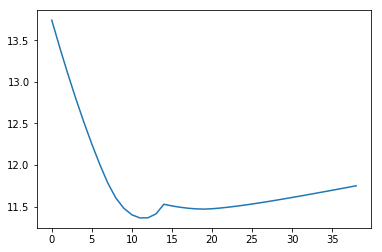

In [11]:
plt.plot(nuc_norms)

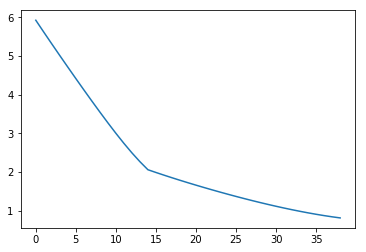

In [12]:
plt.plot(frob_norms)

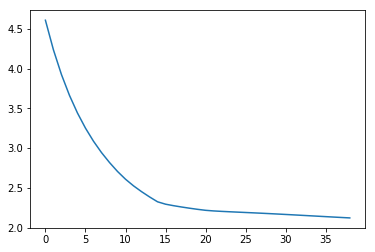

In [13]:
plt.plot(conds)

(array([5., 5., 5., 4., 2., 1., 2., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([2.12084128, 2.14571498, 2.17058867, 2.19546236, 2.22033605,
        2.24520975, 2.27008344, 2.29495713, 2.31983082, 2.34470452,
        2.36957821, 2.3944519 , 2.4193256 , 2.44419929, 2.46907298,
        2.49394667, 2.51882037, 2.54369406, 2.56856775, 2.59344144,
        2.61831514, 2.64318883, 2.66806252, 2.69293621, 2.71780991,
        2.7426836 , 2.76755729, 2.79243099, 2.81730468, 2.84217837,
        2.86705206, 2.89192576, 2.91679945, 2.94167314, 2.96654683,
        2.99142053, 3.01629422, 3.04116791, 3.0660416 , 3.0909153 ,
      

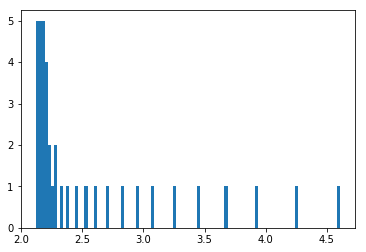

In [14]:
plt.hist(conds,100)

This seems to be working